In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext nb_black
import tensorflow as tf
import math


<IPython.core.display.Javascript object>

## Strategy: Try baseline ML but instead of filtering on population try it on Active.
- Add cosine LR scheduler

In [2]:
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
timeseries = pd.read_csv("../data/processed/timeseries_15_rows_per_county.csv")

<IPython.core.display.Javascript object>

## Understand the data
Timeseries is our train dataset but for each cfip we have taken microdensity instances 1-23 and used 24 as target, 2-24, 25 target and so on

In [3]:
print(f"timeseries shape: {timeseries.shape}")
timeseries.head(20)

timeseries shape: (47025, 29)


,cfips,POPESTIMATE2021,active,target,target_date,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,1001,59095,1249,3.219917,2021-08-01,3.007682,2.884870,3.055843,2.993233,2.993233,...,3.193804,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433
1,1001,59095,1249,3.186722,2021-09-01,2.884870,3.055843,2.993233,2.993233,2.969090,...,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917
2,1001,59095,1249,3.203320,2021-10-01,3.055843,2.993233,2.993233,2.969090,2.909326,...,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722
3,1001,59095,1249,3.200948,2021-11-01,2.993233,2.993233,2.969090,2.909326,2.933231,...,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320
4,1001,59095,1249,3.286307,2021-12-01,2.993233,2.969090,2.909326,2.933231,3.000167,...,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948
5,1001,59095,1249,3.296781,2022-01-01,2.969090,2.909326,2.933231,3.000167,3.004948,...,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307
6,1001,59095,1249,3.334431,2022-02-01,2.909326,2.933231,3.000167,3.004948,3.019292,...,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781
7,1001,59095,1249,3.336785,2022-03-01,2.933231,3.000167,3.004948,3.019292,3.083837,...,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431
8,1001,59095,1249,3.372082,2022-04-01,3.000167,3.004948,3.019292,3.083837,3.174679,...,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785
9,1001,59095,1249,3.313253,2022-05-01,3.004948,3.019292,3.083837,3.174679,3.205756,...,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785,3.372082


<IPython.core.display.Javascript object>

In [4]:
import tensorflow as tf

<IPython.core.display.Javascript object>

## Deep Learning

In [5]:
def build_model():

    inp = tf.keras.Input(shape=(24, 1))

    x = tf.keras.layers.GRU(units=128, return_sequences=False)(inp)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inp, outputs=x)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer=opt)

    return model

<IPython.core.display.Javascript object>

In [6]:
model = build_model()

<IPython.core.display.Javascript object>

In [7]:
model.summary()
LR_MAX = 0.001
LR_MIN = 1e-6 
EPOCHS = 70
BATCH_SIZE = 100

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

Learning rate schedule: 0.001 to 0.001 to 1e-06


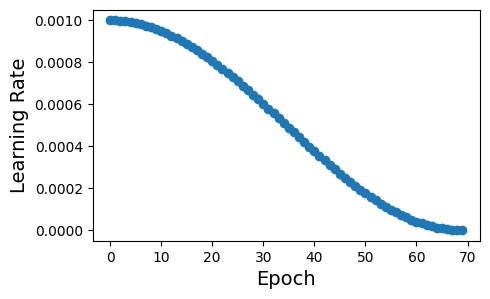

<IPython.core.display.Javascript object>

In [8]:
# a simple cosine learning rate without restart
def lrfn(epoch_i, EPOCHS):

    decay_total_epochs = EPOCHS - 1
    phase = math.pi * epoch_i / decay_total_epochs  # 0 ~ pi
    cosine_decay = 0.5 * (1 + math.cos(phase))
    lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x, EPOCHS) for x in rng]
plt.figure(figsize=(5, 3))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = 0)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [9]:
# find the 50% percentile based on Active
print(f"timeseries shape: {timeseries.shape}, unique cfips: {timeseries['cfips'].nunique()}")
subset_df = timeseries[timeseries["active"] > timeseries["active"].quantile(0.5)]
subset_cfips = subset_df["cfips"].unique()
print(f"subset_df shape after considering only larger pops: {subset_df.shape}, unique cfips: {subset_df['cfips'].nunique()}")
X_subset = subset_df.drop(
    ["target", "target_date", "cfips", "POPESTIMATE2021", "active"], axis=1
)
y_subset = subset_df["target"]

timeseries shape: (47025, 29), unique cfips: 3135
subset_df shape after considering only larger pops: (23490, 29), unique cfips: 1566


<IPython.core.display.Javascript object>

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))
# train with gpu
result = None
with tf.device("/GPU:0"):
    result = model.fit(X_subset, y_subset, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks = [LR])

Num GPUs Available:  0
Epoch 1/70
235/235 [==============================] - 5s 12ms/step - loss: 36.9029 - lr: 0.0010
Epoch 2/70
235/235 [==============================] - 3s 12ms/step - loss: 28.4725 - lr: 1.0025e-06
Epoch 3/70
235/235 [==============================] - 3s 12ms/step - loss: 24.9082 - lr: 0.0010
Epoch 4/70
235/235 [==============================] - 3s 13ms/step - loss: 22.0286 - lr: 1.0222e-06
Epoch 5/70
235/235 [==============================] - 3s 12ms/step - loss: 19.9539 - lr: 0.0010
Epoch 6/70
235/235 [==============================] - 3s 12ms/step - loss: 17.9058 - lr: 1.0617e-06
Epoch 7/70
235/235 [==============================] - 3s 12ms/step - loss: 16.4547 - lr: 0.0010
Epoch 8/70
235/235 [==============================] - 3s 12ms/step - loss: 14.9151 - lr: 1.1210e-06
Epoch 9/70
235/235 [==============================] - 3s 12ms/step - loss: 13.7505 - lr: 0.0010
Epoch 10/70
235/235 [==============================] - 3s 12ms/step - loss: 12.6194 - lr: 1.2000e

<IPython.core.display.Javascript object>

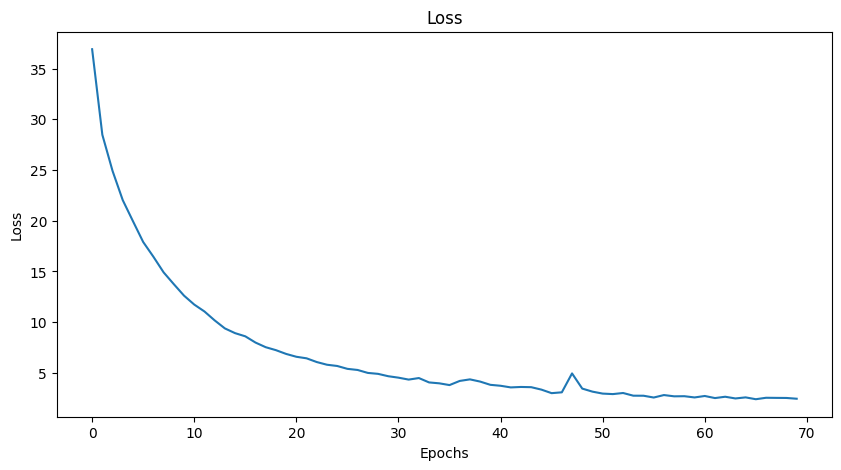

<IPython.core.display.Javascript object>

In [11]:
# plot the loss
fig = plt.figure(figsize=(10, 5))
plt.plot(result.history["loss"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Try LSTM 3 layers

In [27]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.Input(shape=(24, 1)))
model2.add(tf.keras.layers.LSTM(75, return_sequences=True))
model2.add(tf.keras.layers.LSTM(units=30, return_sequences=True))
model2.add(tf.keras.layers.LSTM(units=30))
model2.add(tf.keras.layers.Dense(units=1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()
model2.compile(loss=loss, optimizer=opt)

<IPython.core.display.Javascript object>

In [28]:
model2.summary()
LR_MAX = 0.001
LR_MIN = 1e-6 
EPOCHS = 140
BATCH_SIZE = 100

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 75)            23100     
                                                                 
 lstm_4 (LSTM)               (None, 24, 30)            12720     
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 43,171
Trainable params: 43,171
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

Learning rate schedule: 0.001 to 0.001 to 1e-06


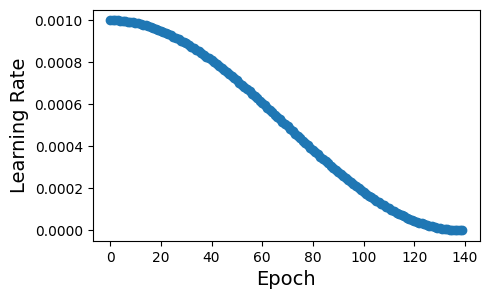

<IPython.core.display.Javascript object>

In [29]:
# a simple cosine learning rate without restart
def lrfn(epoch_i, EPOCHS):

    decay_total_epochs = EPOCHS - 1
    phase = math.pi * epoch_i / decay_total_epochs  # 0 ~ pi
    cosine_decay = 0.5 * (1 + math.cos(phase))
    lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x, EPOCHS) for x in rng]
plt.figure(figsize=(5, 3))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = 0)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [30]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))
# train with gpu
result = None
with tf.device("/GPU:0"):
    result = model2.fit(X_subset, y_subset, epochs=EPOCHS,batch_size=BATCH_SIZE, callbacks = [LR])

Num GPUs Available:  0
Epoch 1/140
235/235 [==============================] - 7s 19ms/step - loss: 49.1623 - lr: 0.0010
Epoch 2/140
235/235 [==============================] - 4s 19ms/step - loss: 40.0861 - lr: 1.0025e-06
Epoch 3/140
235/235 [==============================] - 4s 19ms/step - loss: 37.2198 - lr: 0.0010
Epoch 4/140
235/235 [==============================] - 4s 19ms/step - loss: 34.9603 - lr: 1.0222e-06
Epoch 5/140
235/235 [==============================] - 4s 19ms/step - loss: 33.2902 - lr: 0.0010
Epoch 6/140
235/235 [==============================] - 4s 19ms/step - loss: 31.7453 - lr: 1.0617e-06
Epoch 7/140
235/235 [==============================] - 5s 19ms/step - loss: 30.4196 - lr: 0.0010
Epoch 8/140
235/235 [==============================] - 5s 20ms/step - loss: 29.1663 - lr: 1.1210e-06
Epoch 9/140
235/235 [==============================] - 5s 20ms/step - loss: 28.0329 - lr: 0.0010
Epoch 10/140
235/235 [==============================] - 5s 20ms/step - loss: 26.9678 - l

<IPython.core.display.Javascript object>

## Predictions


In [16]:
ids = test["cfips"].unique()
predictions = np.zeros((len(ids), 8))
test_df = timeseries[timeseries["target_date"] == timeseries["target_date"].max()].drop(
    ["target_date", "POPESTIMATE2021", "active", "cfips"], axis=1
)

<IPython.core.display.Javascript object>

In [17]:
timeseries.head(20)

,cfips,POPESTIMATE2021,active,target,target_date,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
0,1001,59095,1249,3.219917,2021-08-01,3.007682,2.884870,3.055843,2.993233,2.993233,...,3.193804,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433
1,1001,59095,1249,3.186722,2021-09-01,2.884870,3.055843,2.993233,2.993233,2.969090,...,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917
2,1001,59095,1249,3.203320,2021-10-01,3.055843,2.993233,2.993233,2.969090,2.909326,...,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722
3,1001,59095,1249,3.200948,2021-11-01,2.993233,2.993233,2.969090,2.909326,2.933231,...,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320
4,1001,59095,1249,3.286307,2021-12-01,2.993233,2.969090,2.909326,2.933231,3.000167,...,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948
5,1001,59095,1249,3.296781,2022-01-01,2.969090,2.909326,2.933231,3.000167,3.004948,...,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307
6,1001,59095,1249,3.334431,2022-02-01,2.909326,2.933231,3.000167,3.004948,3.019292,...,3.224659,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781
7,1001,59095,1249,3.336785,2022-03-01,2.933231,3.000167,3.004948,3.019292,3.083837,...,3.227030,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431
8,1001,59095,1249,3.372082,2022-04-01,3.000167,3.004948,3.019292,3.083837,3.174679,...,3.222288,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785
9,1001,59095,1249,3.313253,2022-05-01,3.004948,3.019292,3.083837,3.174679,3.205756,...,3.210433,3.219917,3.186722,3.203320,3.200948,3.286307,3.296781,3.334431,3.336785,3.372082


<IPython.core.display.Javascript object>

In [18]:
test_df.head()

,target,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
14,3.463856,3.193804,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,...,3.286307,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677
29,8.359798,8.329126,8.263252,8.224466,8.011045,7.909001,7.978031,8.032654,8.061466,8.077073,...,7.930010,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701
44,1.232074,1.037059,1.032144,1.032144,1.111998,1.072105,1.057146,1.102025,1.097038,1.107011,...,1.151890,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827
59,1.287240,1.326394,1.320797,1.309604,1.310044,1.287650,1.287650,1.259657,1.259657,1.237263,...,1.209271,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346
74,1.831783,1.641125,1.641125,1.613962,1.612029,1.688793,1.700081,1.702339,1.720401,1.713628,...,1.752009,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060


<IPython.core.display.Javascript object>

In [19]:
test_df[24] =test_df["target"]
test_df.drop(["target","0"], axis=1, inplace=True)
test_df.columns = range(0,24)
test_df.head()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
14,3.038416,3.002558,2.947244,3.106106,3.144043,3.224659,3.227030,3.222288,3.210433,3.219917,...,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856
29,8.263252,8.224466,8.011045,7.909001,7.978031,8.032654,8.061466,8.077073,7.984033,7.918605,...,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798
44,1.032144,1.032144,1.111998,1.072105,1.057146,1.102025,1.097038,1.107011,1.146903,1.156876,...,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827,1.232074
59,1.320797,1.309604,1.310044,1.287650,1.287650,1.259657,1.259657,1.237263,1.237263,1.209271,...,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346,1.287240
74,1.641125,1.613962,1.612029,1.688793,1.700081,1.702339,1.720401,1.713628,1.715885,1.711370,...,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783


<IPython.core.display.Javascript object>

In [20]:
test_df.shape

(3135, 24)

<IPython.core.display.Javascript object>

In [21]:
print("Start inference")
for i in range(8):
    predictions[:, i] = model.predict(test_df).reshape(-1)
    print(f"prediction{i+1} : {predictions[:, i]}")
    print(predictions.shape)
    test_df[i + 24] = predictions[:, i]
    test_df.drop(0, axis=1, inplace=True)
    test_df.columns = range(0, 24)

Start inference
98/98 [==============================] - 0s 2ms/step
prediction1 : [3.45420599 8.43375683 1.21037567 ... 3.9844141  3.12542439 1.76871312]
(3135, 8)
98/98 [==============================] - 0s 2ms/step
prediction2 : [3.44448376 8.4782629  1.19161165 ... 3.95817566 3.12105703 1.75240386]
(3135, 8)
98/98 [==============================] - 0s 2ms/step
prediction3 : [3.44524717 8.51806068 1.16868436 ... 3.91199017 3.13129663 1.73588932]
(3135, 8)
98/98 [==============================] - 0s 2ms/step
prediction4 : [3.43452835 8.57249069 1.14491093 ... 3.89339638 3.11467361 1.7136935 ]
(3135, 8)
98/98 [==============================] - 0s 2ms/step
prediction5 : [3.42364025 8.63014793 1.11929524 ... 3.86809778 3.08546209 1.68789923]
(3135, 8)
98/98 [==============================] - 0s 2ms/step
prediction6 : [3.40501165 8.68739223 1.09057915 ... 3.84568739 3.05646753 1.66135156]
(3135, 8)
98/98 [==============================] - 0s 2ms/step
prediction7 : [3.38454199 8.74412441 

<IPython.core.display.Javascript object>

In [22]:
test.sort_values(["cfips", "first_day_of_month"], inplace=True)

<IPython.core.display.Javascript object>

In [23]:
test["microbusiness_density"] = predictions.reshape(-1)

<IPython.core.display.Javascript object>

In [24]:
test.head(8)

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.454206
3135,1001_2022-12-01,1001,2022-12-01,3.444484
6270,1001_2023-01-01,1001,2023-01-01,3.445247
9405,1001_2023-02-01,1001,2023-02-01,3.434528
12540,1001_2023-03-01,1001,2023-03-01,3.423640
15675,1001_2023-04-01,1001,2023-04-01,3.405012
18810,1001_2023-05-01,1001,2023-05-01,3.384542
21945,1001_2023-06-01,1001,2023-06-01,3.362402


<IPython.core.display.Javascript object>

In [25]:
result = test[["row_id", "microbusiness_density"]]
result.to_csv("../data/submissions/dl_test_1.csv", index=False)

<IPython.core.display.Javascript object>

### Plot some stuff

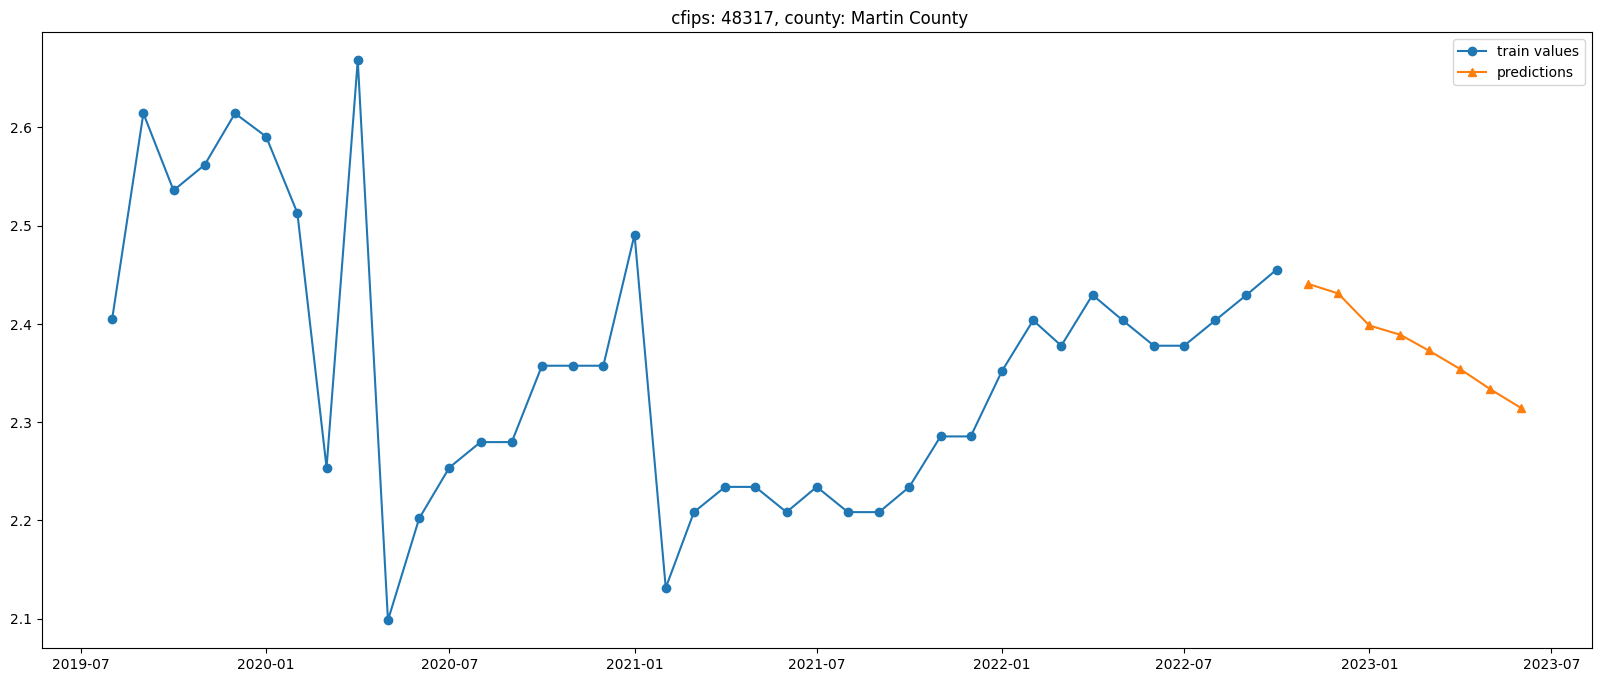

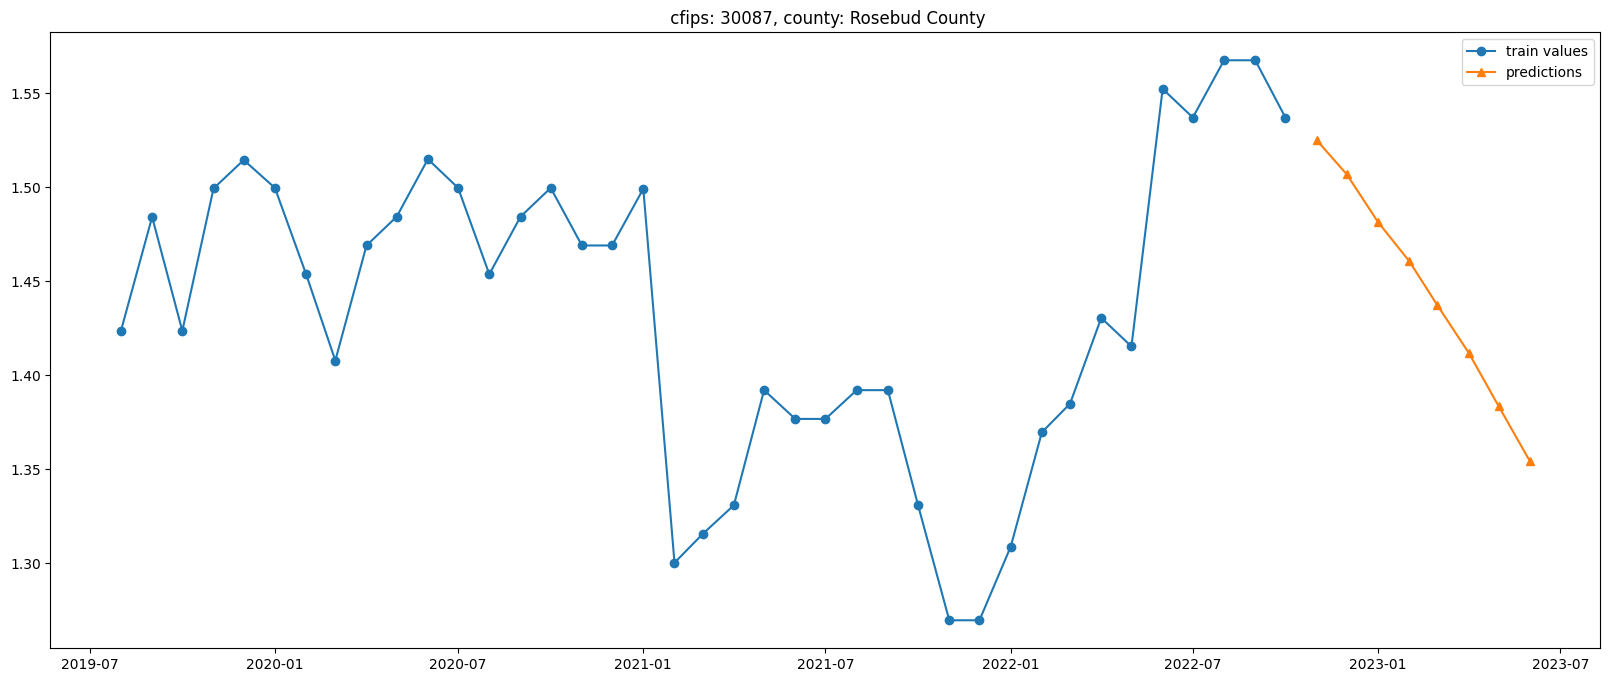

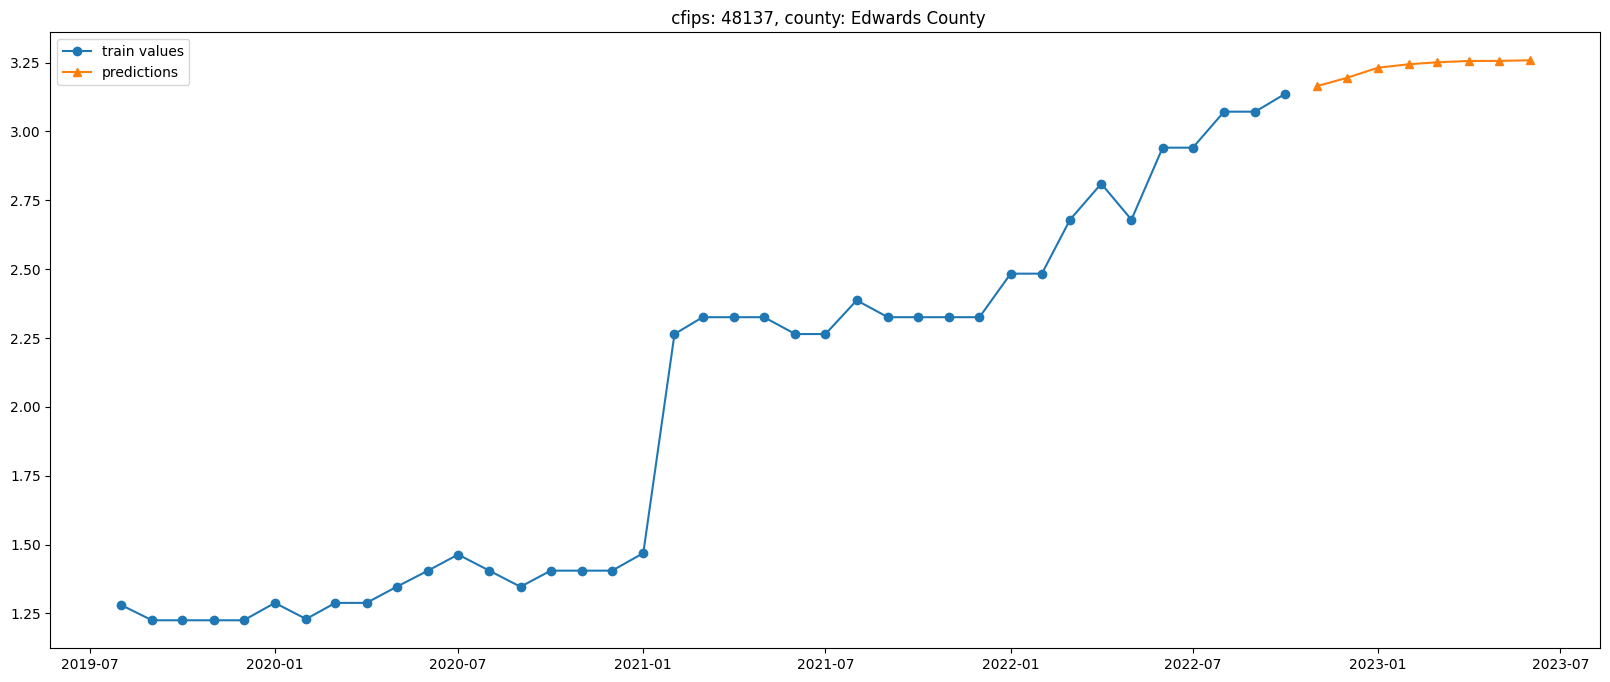

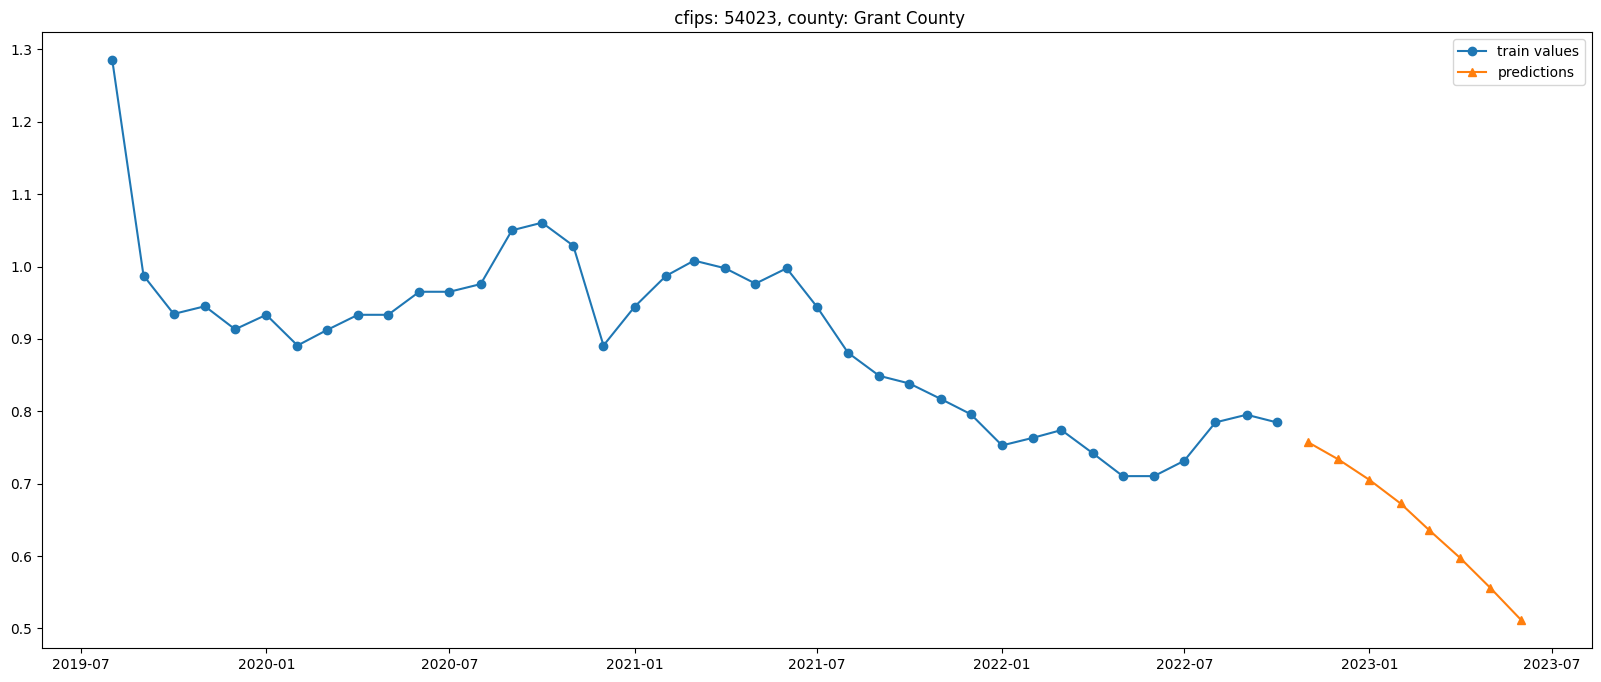

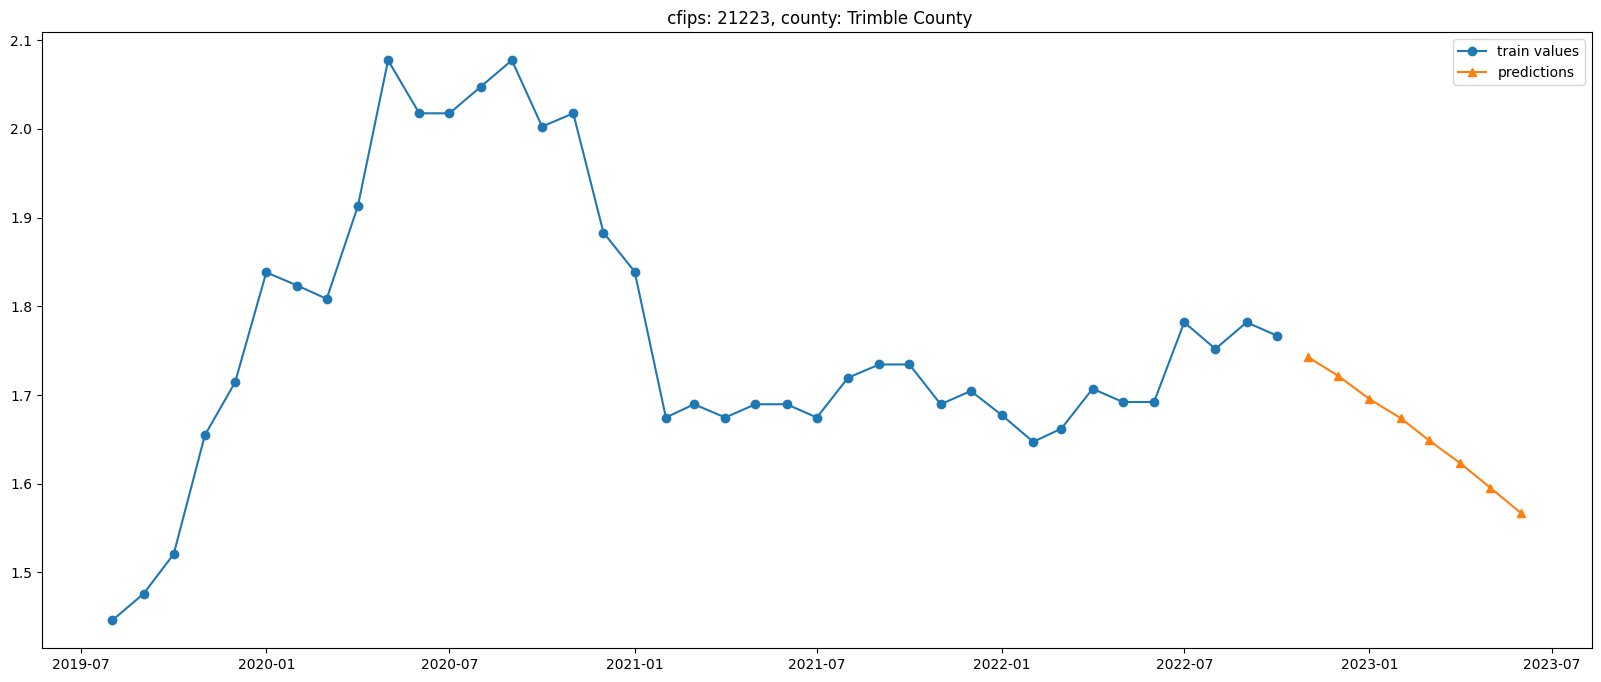

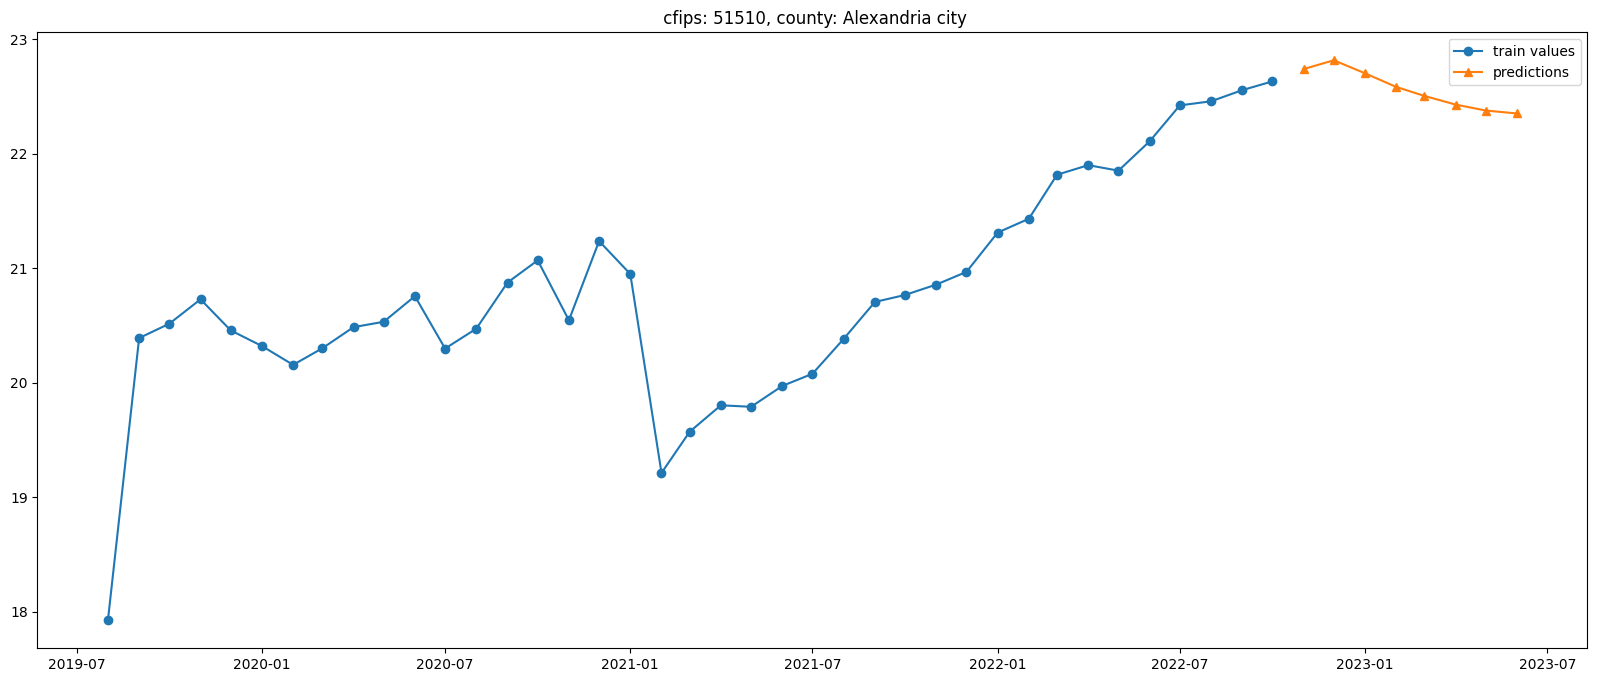

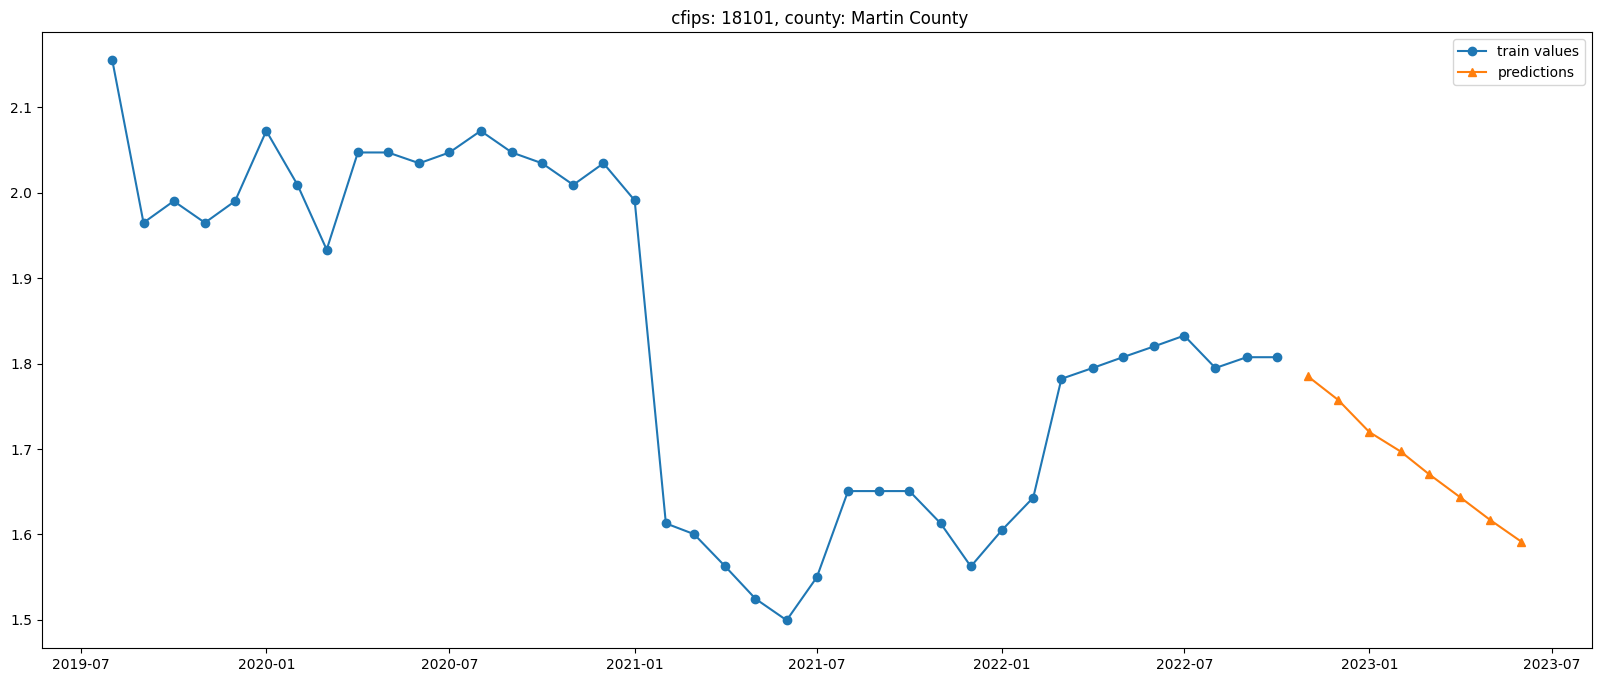

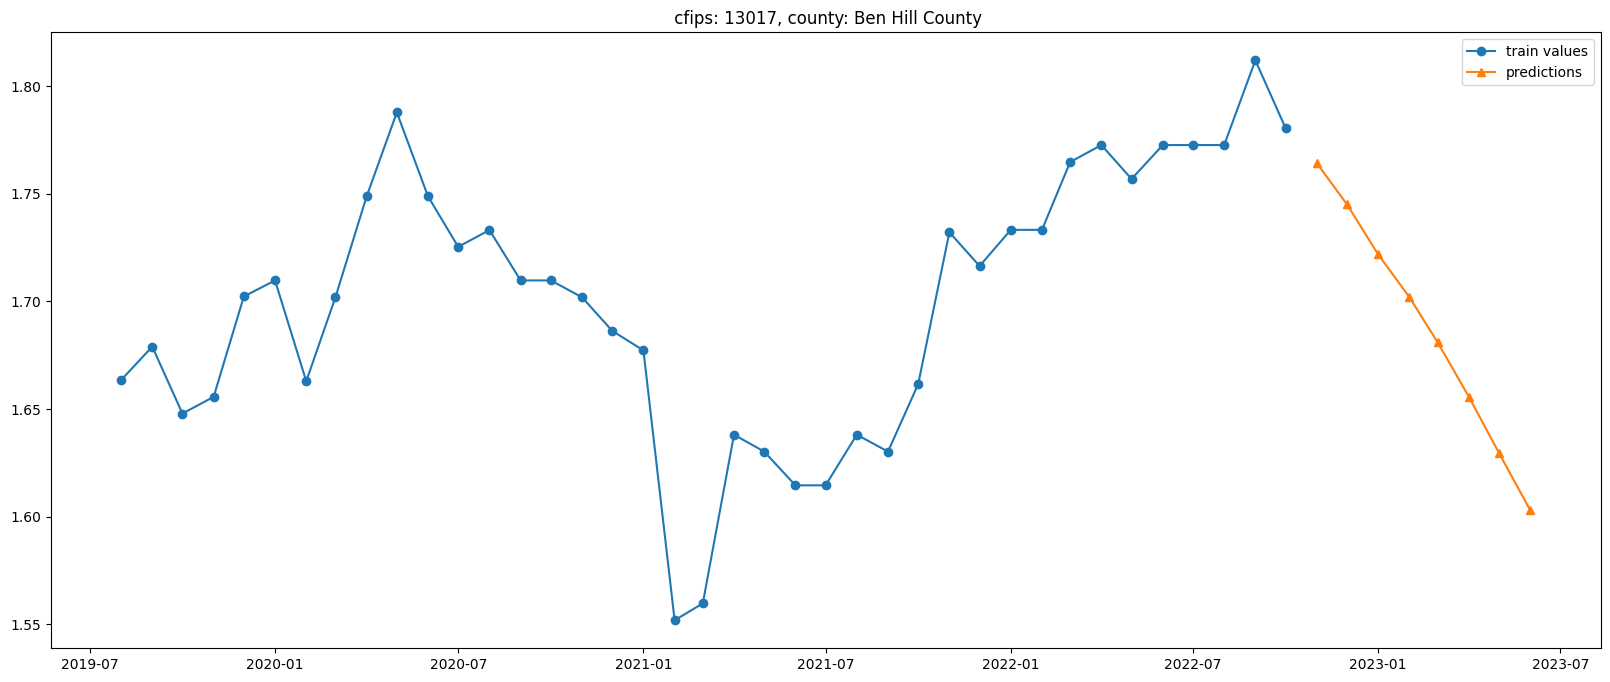

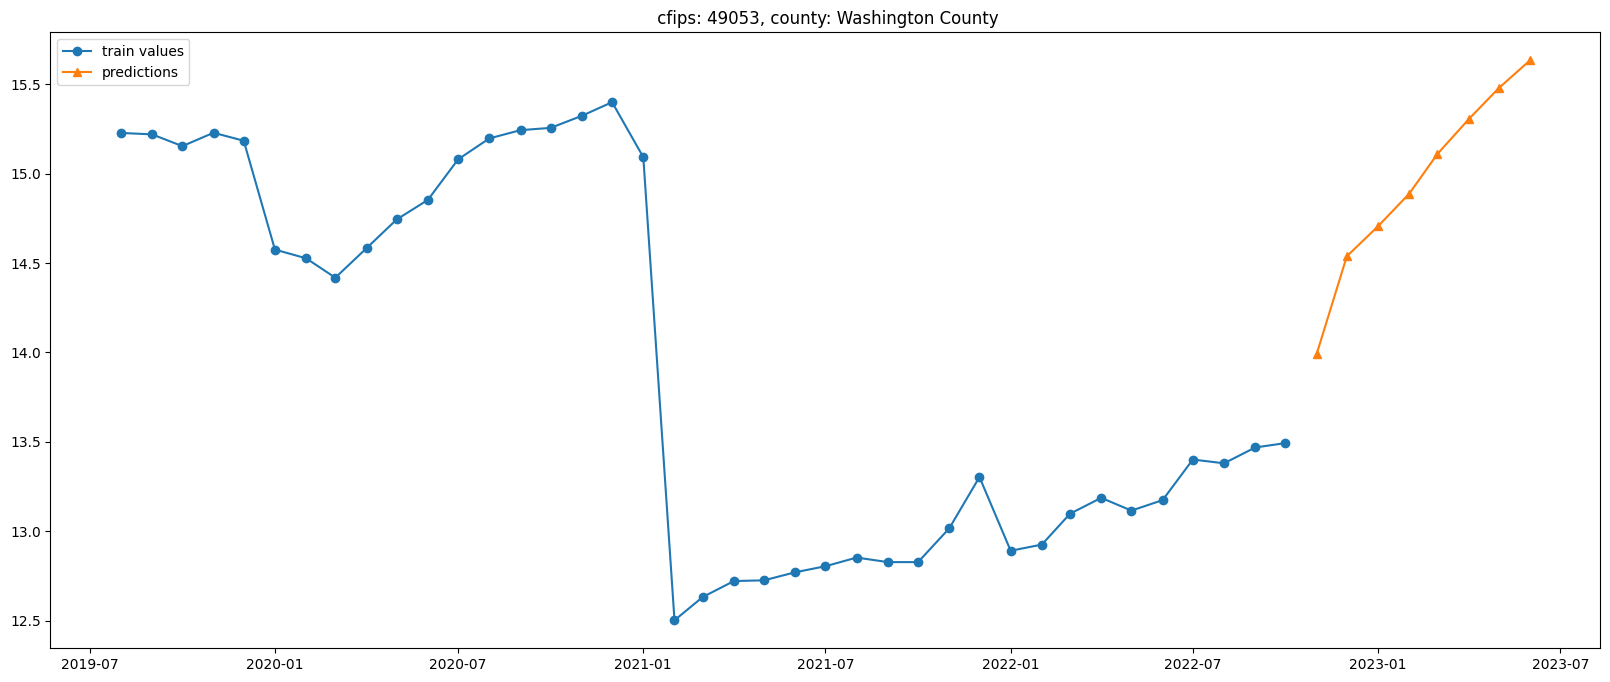

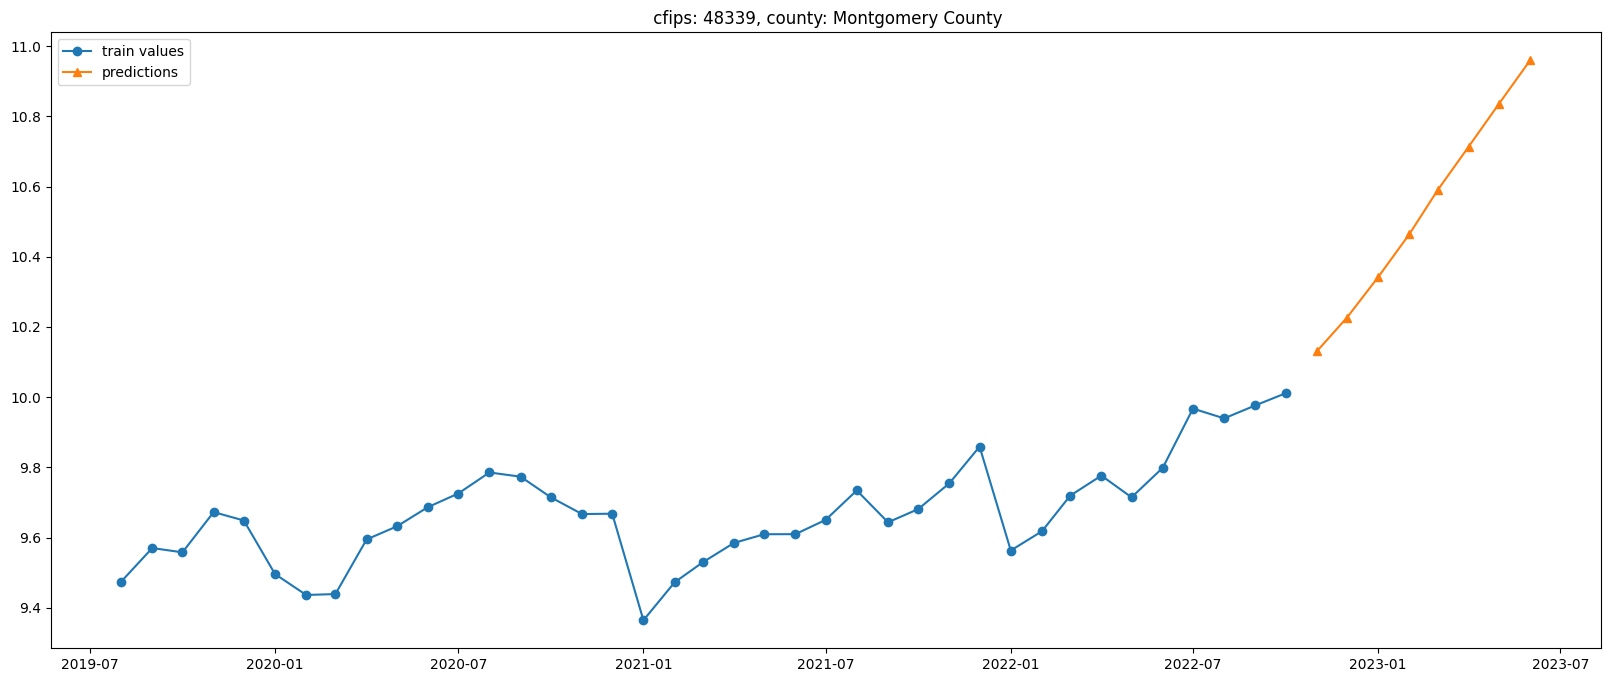

<IPython.core.display.Javascript object>

In [26]:
for i in range(10):
    c = np.random.choice(ids)
    plot_df = train[train["cfips"] == c].copy()
    test_plot = test[test["cfips"] == c].copy()
    plot_df["first_day_of_month"]= pd.to_datetime(plot_df["first_day_of_month"])
    test_plot["first_day_of_month"]= pd.to_datetime(test_plot["first_day_of_month"])
    last_target = plot_df["microbusiness_density"].values[-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(
        plot_df["first_day_of_month"],
        plot_df["microbusiness_density"],
        "-o",
        label="train values",)
    plt.plot(
    test_plot["first_day_of_month"], test_plot["microbusiness_density"], "-^", label="predictions"
    )
    plt.title(f" cfips: {c}, county: {plot_df['county'].values[0]}")
    plt.legend()
    plt.show()